<a href="https://colab.research.google.com/github/am-tropin/georgian-letters-trainer/blob/main/Georgian_letters_recognition_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 0. Libraries**

In [15]:
from keras.models import Sequential


In [16]:
import tensorflow as tf

import tensorflow_datasets as tfds

# tf.enable_eager_execution()

In [17]:
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image
# import theano

**Step 1. Choose a dataset**

In [18]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import opendatasets as od
import pandas

In [21]:
od.download("https://www.kaggle.com/datasets/alexandertropin/georgian-letters-photo-database")

Skipping, found downloaded files in "./georgian-letters-photo-database" (use force=True to force download)


In [22]:
# remove all .txt files

import os
import glob
fileList = glob.glob('georgian-letters-photo-database/*.txt')

for filePath in fileList:
    os.remove(filePath)

**Step 2. To chop up the letters**

In [23]:
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile


In [24]:
# https://github.com/Shenggan/BCCD_Dataset/blob/master/export.py

annotations = glob('georgian-letters-photo-database/*.xml')

df = []
cnt = 0

for file in annotations:
    filename = file.split('/')[-1].split('.')[0] + '.jpg'
    row = []
    parsedXML = ET.parse(file)
    for node in parsedXML.getroot().iter('object'):
        letters = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)

        row = [filename, letters, xmin, xmax, ymin, ymax]
        df.append(row)
        cnt += 1

data = pd.DataFrame(df, columns=['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax'])

data[['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('test.csv', index=False)

In [25]:
df = pd.read_csv('test.csv')
df.head()

,filename,letter_name,xmin,xmax,ymin,ymax
0,IMG_20230213_212214.jpg,18ტ,578,841,1167,1520
1,IMG_20230213_212214.jpg,19უ,812,1029,1187,1475
2,IMG_20230213_212214.jpg,16რ,1006,1220,1187,1501
3,IMG_20230213_212214.jpg,1ბ,1197,1401,1190,1498
4,IMG_20230213_212214.jpg,13ო,1385,1689,1206,1511


In [27]:
# for index, row in df.iterrows():
#     print(row['letter_name'], row['xmin'])

In [28]:
import cv2
from google.colab.patches import cv2_imshow


In [32]:
!mkdir cropped_images

In [30]:
letter_names = set(list(df['letter_name']))
# letter_names

In [76]:
def reverse_image(img_test):
    height, width = img_test.shape[:2]
    border_delta = 0.02

    # mean grayscale value
    mean_image = np.mean(img_test)

    # grayscale values near the borders
    mean_left_border = np.mean(img_test[:, int(width*(1-border_delta)):width])
    mean_right_border = np.mean(img_test[:, 0:int(width*border_delta)])
    mean_upper_border = np.mean(img_test[0:int(height*border_delta), :])
    mean_lower_border = np.mean(img_test[int(height*(1-border_delta)):height, :])

    if mean_image > np.mean(np.array([mean_left_border, mean_right_border, mean_upper_border, mean_lower_border])):
        return cv2.bitwise_not(img_test)
    else:
        return img_test


In [43]:
df_short = df.head(30)

In [77]:
# REPLACE BACK df_short WITH df

'''
Creating a new dataset of images with singular letters.
Grayscale. 
Resized to 200x300.
Inverted (black <-> white) if the borders are darker than the image on the average
'''

for index, row in df_short.iterrows():
    img = cv2.imread("georgian-letters-photo-database/" + row['filename'])
    crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
    letter_counter = {}
    for letter_name in letter_names:
        letter_counter[letter_name] = 0
    letter_counter[row['letter_name']] += 1
    crop_resize_img = cv2.resize(crop_img, (200, 300))
    gray_crop_resize_img = cv2.cvtColor(crop_resize_img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('cropped_images/' + row['filename'][:-4] + '_' + row['letter_name'][-1] + '_' + str(letter_counter[row['letter_name']]) + '.jpg', reverse_image(gray_crop_resize_img))


In [45]:
# import os
# import glob

# files = glob.glob('cropped_images/*')
# for f in files:
#     os.remove(f)

In [47]:
# !rmdir croped_images

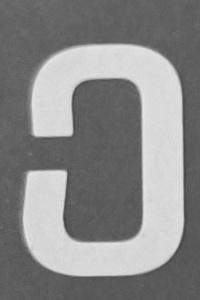

In [51]:
img_test = cv2.imread("/content/cropped_images/IMG_20230212_163114_ე_1.jpg")

cv2_imshow(img_test)


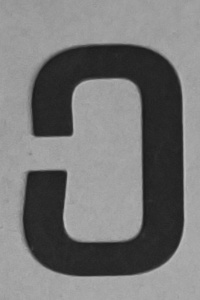

In [75]:
cv2_imshow(reverse_image(img_test))


In [53]:
# threshold
thresh = cv2.threshold(img_test, 180, 255, cv2.THRESH_BINARY)[1]

# count number of white pixels
mean = np.mean(img_test)
print("mean =", mean)

mean_masked = np.mean(img_test[np.where(thresh == 255)])
print("masked mean =", mean_masked)


mean = 136.24663333333334
masked mean = 215.07470801449858


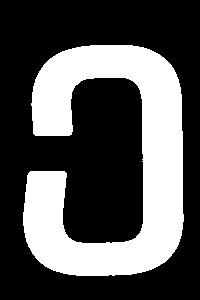

-1

In [56]:
# write thresh to disk
cv2.imwrite("gray_with_spots_thresh.png", thresh)

# display it
cv2_imshow(thresh)
cv2.waitKey(0)

In [49]:

# img = cv2.imread("georgian-letters-photo-database/IMG_20230213_212214.jpg")
# crop_img = img[1167:1520, 578:841]
# # cv2.imshow("cropped", crop_img) 
# # cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
# # to crash; see https://github.com/jupyter/notebook/issues/3935.
# # As a substitution, consider using
# #   from google.colab.patches import cv2_imshow
# cv2_imshow(crop_img)
# cv2.waitKey(0)

**======= DRAFTS =======**

**======= DRAFTS =======**

**======= DRAFTS =======**

**Step 3. To create copies of images with rectangles of letters**

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import os


In [14]:
# https://github.com/Shenggan/BCCD_Dataset/blob/master/plot.py

def filterFiles(directoryPath, extension):
    """
        This function filters the format files with the selected extension in the directory
        
        Args:
            directoryPath (str): relative path of the directory that contains text files
            extension (str): extension file
        Returns:
            The list of filtered files with the selected extension
    """    
    relevant_path = directoryPath
    included_extensions = [extension]
    file_names = [file1 for file1 in os.listdir(relevant_path) if any(file1.endswith(ext) for ext in included_extensions)]
    numberOfFiles = len(file_names)
    listParams = [file_names, numberOfFiles]
    return listParams

ImageName: IMG_20230205_132210.jpg is saved in imagesBox folder
ImageName: IMG_20230215_140933 (1).jpg is saved in imagesBox folder


UnidentifiedImageError: ignored

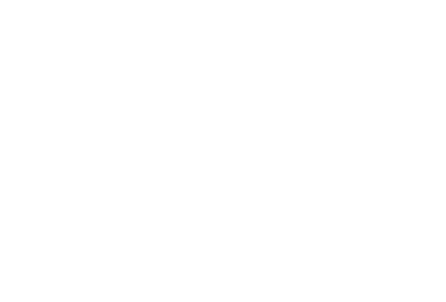

In [19]:
[image_names, numberOfFiles] = filterFiles("georgian-letters-photo-database", "jpg")    

trainRCNN = pd.read_csv('test.csv', sep=",", header=None)
trainRCNN.columns = ['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax']
trainRCNN.head()

for imageFileName in image_names:    
    fig = plt.figure()
    #add axes to the image
    ax = fig.add_axes([0,0,1,1]) #adding X and Y axes from 0 to 1 for each direction 
    plt.axis('off')

    # read and plot the image
    image = plt.imread('georgian-letters-photo-database/' + imageFileName)
    plt.imshow(image)
    # iterating over the image for different objects
    for _, row in trainRCNN[trainRCNN.filename == imageFileName].iterrows():
        xmin = float(row.xmin)
        xmax = float(row.xmax)
        ymin = float(row.ymin)
        ymax = float(row.ymax)
        
        width = xmax - xmin
        height = ymax - ymin
        ClassName = row.letter_name

        ax.annotate(ClassName, xy=(xmax-40, ymin+20))
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = 'r', facecolor = 'none')

        # assign different color to different classes of objects
        # if row.letter_name == 'RBC':
        #     ax.annotate('RBC', xy=(xmax-40,ymin+20))
        #     rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = 'r', facecolor = 'none')
        # elif row.letter_name == 'WBC':
        #     ax.annotate('WBC', xy=(xmax-40,ymin+20))
        #     rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = 'b', facecolor = 'none')
        # elif row.letter_name == 'Platelets':
        #     ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        #     rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = 'g', facecolor = 'none')        
        # else:
        #     print("nothing")
    
        ax.add_patch(rect)   
        if not os.path.exists("imagesBox"):
            os.makedirs("imagesBox")

        fig.savefig('imagesBox/' + imageFileName, dpi=90, bbox_inches='tight')
    plt.close()
    print("ImageName: " + imageFileName + " is saved in imagesBox folder")
        
print("PLOTBOX COMPLETED!")

**Step 1. Splitting on train (80%) and test sets**

...

In [ ]:
# #creating two dir for training and testing
# !mkdir test_labels train_labels

# # lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# # Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
# !ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/

# # Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
# !ls annotations/* | xargs -I{} mv {} train_labels/

In [6]:
#creating two dir for training and testing
!mkdir test_labels train_labels

In [11]:
#creating two dir for training and testing
!mkdir test train

In [7]:
# 86 * 0.2

17.2

In [10]:
# Moves the first 51/86 labels (20% of the labels) to the testing dir: `test_labels`
!ls georgian-letters-photo-database/* | head -51 | xargs -I{} mv {} test/

# to cancel:
# !ls test/* | xargs -I{} mv {} georgian-letters-photo-database/

In [13]:
!ls georgian-letters-photo-database/* | xargs -I{} mv {} train/